# HW2 - eCommerce analytics
#### *Elisa Valeriani & Iyuele A. Korsaye* 

### Import libraries
First of all, we need to import the libraries we'll need to solve our exercises, like pandas to work with dataframes and matplotlib to plot graphs

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import dask
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client, progress

### Start Dask Client for Dashboard
- The Dask Client will provide a dashboard which is useful to gain insight on the computation going on

In [2]:
client = Client()  
client

Client Scheduler: tcp://127.0.0.1:57331 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 8.46 GB


### Read Dask DataFrame        
- Read all the csv dataframes as one logical dataframe using the dd.read_csv function     

In [42]:
df = dd.read_csv('2019-*.csv', parse_dates=['event_time'])

### Write to Parquet
- a format that is more efficient for computers to read and write

In [43]:
df.to_parquet('2019.parquet', engine='pyarrow')

### Read from Parquet

In [44]:
df = dd.read_parquet('2019.parquet', engine='pyarrow')

## *RQ1.1*
#### *What's the operation users repeat more on average within a session? Produce a plot that shows the average number of times users perform each operation (view/removefromchart etc etc).*

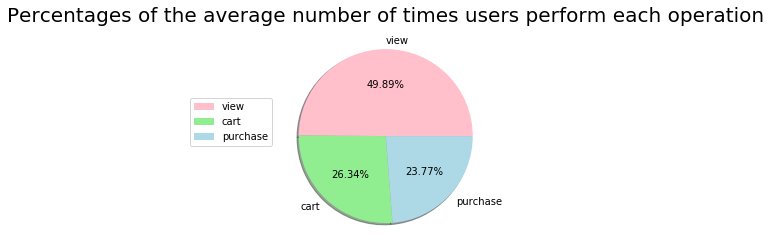

In [3]:
#Ex 1.1

#initialize 3 empty dataframes
v_view = pd.DataFrame()
v_cart = pd.DataFrame()
v_purchase = pd.DataFrame()

#for each chunck of October's dataset...
for chunck in pd.read_csv('2019-Oct.csv', usecols = ['user_session', 'event_type'], nrows =100000, chunksize=1000, iterator = True):

#...count the number of times per session a product was seen...
        views = pd.DataFrame(chunck[chunck.event_type == 'view'].groupby(['user_session']).event_type.count())
        v_view = v_view.append(views)
        
#...put in the cart...
        carts = pd.DataFrame(chunck[chunck.event_type == 'cart'].groupby(['user_session']).event_type.count())
        v_cart = v_cart.append(carts)
        
#...bought...
        purchases = pd.DataFrame(chunck[chunck.event_type == 'purchase'].groupby(['user_session']).event_type.count())
        v_purchase = v_purchase.append(purchases)
        
#the same for each chunck of November's dataset
for chunck in pd.read_csv('2019-Nov.csv', usecols = ['user_session', 'event_type'], nrows =100000, chunksize=1000, iterator = True):
    
        views = pd.DataFrame(chunck[chunck.event_type == 'view'].groupby(['user_session']).event_type.count())
        v_view = v_view.append(views)
        carts = pd.DataFrame(chunck[chunck.event_type == 'cart'].groupby(['user_session']).event_type.count())
        v_cart = v_cart.append(carts)
        purchases = pd.DataFrame(chunck[chunck.event_type == 'purchase'].groupby(['user_session']).event_type.count())
        v_purchase = v_purchase.append(purchases)
        
#repeat the same process for the dataframes filled with information
v_view = v_view.groupby('user_session').event_type.count().mean()
v_cart = v_cart.groupby('user_session').event_type.count().mean()
v_purchase = v_purchase.groupby('user_session').event_type.count().mean()

#plot a pie plot (suitable because we have just a few numeric quantities to show)
my_labels = ("view", "cart", "purchase")
my_colors = ("pink", "lightgreen", "lightblue")
plt.pie([v_view, v_cart, v_purchase], labels = my_labels, autopct = "%.2f%%", colors= my_colors, shadow = True)
plt.title("Percentages of the average number of times users perform each operation", fontsize = 20)
plt.legend(bbox_to_anchor=(0,.7))
plt.show()


#### Comment
From this pie plot we can see that the most repeated operation within a session is 'view' (almost half of the times), while cart and purchase follow (togheter these operations are repeated more than half of the times) 

## *RQ1.2*
#### *How many times, on average, a user views a product before adding it to the cart?*

In [4]:
#Ex 1.2

#initialize 2 empty numeric variables
my_sum = 0
i = 0

#for each chunck of October's dataset...
for chunck in pd.read_csv('2019-Oct.csv', usecols = ['user_id', 'product_id', 'event_type'], nrows =100000, chunksize=1000, iterator = True):

#...for each couple (user, product) where the user put the product in the cart...
    for e, frame in chunck[chunck.event_type == 'cart'].groupby(['user_id', 'product_id']):

#...increase my_sum of one and i of the number of times THE user has seen THE product
        my_sum += 1
        i += chunck[(chunck.user_id == e[0]) & (chunck.product_id == e[1]) & (chunck.event_type == 'views')].shape[0]

#the same for each chunck of November's dataset
for chunck in pd.read_csv('2019-Nov.csv', usecols = ['user_id', 'product_id', 'event_type'], nrows =100000, chunksize=1000, iterator = True):
    
    for e, frame in chunck[chunck.event_type == 'cart'].groupby(['user_id', 'product_id']):
        
        my_sum += 1
        i += chunck[(chunck.user_id == e[0]) & (chunck.product_id == e[1]) & (chunck.event_type == 'views')].shape[0]

#if at least a user put a product in the cart...
if my_sum != 0:
    
    res = int(i/my_sum) 
    print("On average, a user views a product before adding it to the cart "+ str(res) +" times")
    
#...else...
else:
    print("Not even one user has added a product to the cart")
 

On average, a user views a product before adding it to the cart 0 times


#### Comment
This result shows that, on average, the user never looks at the product before putting it in the cart

## *RQ1.3*
#### *What's the probability that products added once to the cart are effectively bought?*

In [5]:
#Ex 1.3

#initialize 2 empty numeric variables
my_sum = 0
i = 0

#for each chunck of October's dataset...
for chunck in pd.read_csv('2019-Oct.csv', usecols = ['user_id', 'product_id', 'event_type'], nrows =100000, chunksize=1000, iterator = True):
    
#...for each couple (user, product) where the user put the product in the cart...
    for e, frame in chunck[chunck.event_type == 'cart'].groupby(['user_id', 'product_id']):
        
#...if THE user put THE product in the cart just once...
        if len(chunck[(chunck.user_id == e[0]) & (chunck.product_id == e[1]) & (chunck.event_type == 'cart')]) == 1: 
        
#...increase my_sum of one and i of the number of times the user bought the product
                my_sum += 1
                i += chunck[(chunck.user_id == e[0]) & (chunck.product_id == e[1]) & (chunck.event_type == 'purchase')].shape[0]
                
#the same for each chunck of November's dataset
for chunck in pd.read_csv('2019-Nov.csv', usecols = ['user_id', 'product_id', 'event_type'], nrows =100000, chunksize=1000, iterator = True):
    
    for e, frame in chunck[chunck.event_type == 'cart'].groupby(['user_id', 'product_id']):
       
        if len(chunck[(chunck.user_id == e[0]) & (chunck.product_id == e[1]) & (chunck.event_type == 'cart')]) == 1: 
                
                my_sum += 1
                i += chunck[(chunck.user_id == e[0]) & (chunck.product_id == e[1]) & (chunck.event_type == 'purchase')].shape[0]

#if at least a user put a product in the cart just once...  
if my_sum != 0:  
    
    res = round(i/my_sum, 2) 
    print("The probability that a user boughts a product after adding it to the cart is "+ str(res*100) +"%")
    
#...else...
else:
    print("Not even one user has added a product to the cart")
    

The probability that a user boughts a product after adding it to the cart is 18.0%


#### Comment
This result shows that, on average, the user tends to buy the product directly or put it in the cart several times, while only 18 times on 100 he/she tends to put it in the cart and then buy it

## *RQ 1.4*
#### *What's the average time an item stays in the cart before being removed?*

In [6]:
#Ex 1.4 

#In order to solve this exercise, we consider the event 'remove a product from the cart' as the event 'buy a product after putting it in the cart'

#initialize 2 empty numeric variables
my_sum = 0
time = 0

#for each chunck of October's dataset...
for chunck in pd.read_csv('2019-Oct.csv', usecols = ['user_id', 'product_id', 'event_type', 'event_time'], nrows =100000, chunksize=1000, iterator = True, parse_dates = ['event_time'], date_parser = pd.to_datetime):

#...for each couple (user, product) where the user bought the product...
    for e, frame in chunck[chunck.event_type == 'purchase'].groupby(['user_id', 'product_id']):
    
#...increase my_sum of one and time of the seconds passed between the events 'the user put the product in the cart for the 1st time' and 'the user bought the product'
        my_chunck = chunck[(chunck.user_id == e[0]) & (chunck.product_id == e[1])]
        chunck_cart = my_chunck[my_chunck.event_type == 'cart']
        if len(chunck_cart) != 0:
            
            first_cart = min(chunck_cart.event_time).second
            first_purchase = min(my_chunck[my_chunck.event_type == 'purchase'].event_time).second
            if first_purchase >= first_cart:
                time += first_purchase - first_cart
                my_sum += 1

#the same for each chunck of November's dataset
for chunck in pd.read_csv('2019-Nov.csv', usecols = ['user_id', 'product_id', 'event_type', 'event_time'], nrows =100000, chunksize=1000, iterator = True, parse_dates = ['event_time'], date_parser = pd.to_datetime):

    for e, frame in chunck[chunck.event_type == 'purchase'].groupby(['user_id', 'product_id']):
    
        my_sum += 1
        my_chunck = chunck[(chunck.user_id == e[0]) & (chunck.product_id == e[1])]
        chunck_cart = my_chunck[my_chunck.event_type == 'cart']
        if len(chunck_cart) != 0:
            
            first_cart = min(chunck_cart.event_time).second
            first_purchase = min(my_chunck[my_chunck.event_type == 'purchase'].event_time).second
            if first_purchase >= first_cart:
                time += first_purchase - first_cart
                my_sum += 1
        
#if at least a user bought a product...
if my_sum != 0:
    
    res = int(time/my_sum)
    print("On average, an item stays in the cart before being removed "+ str(res) +" second(s)")

#...else...
else:
    
    print("Not even one user has removed a product from the cart")
    

On average, an item stays in the cart before being removed 2 second(s)


#### Comment
This result shows that, on average, an item stays in the cart for just 2 seconds, and then it is almost immediately bought

## *RQ 1.5*
#### *How much time passes on average between the first view time and a purchase/addition to cart?*

In [ ]:
#Ex 1.5 

#initialize 3 empty numeric variables
my_sum = 0
my_min = 0
time = 0

#for each chunck of October's dataset...
for chunck in pd.read_csv('2019-Oct.csv', usecols = ['user_id', 'product_id', 'event_type', 'event_time'], nrows = 100000, chunksize=1000, iterator = True, parse_dates = ['event_time'], date_parser = pd.to_datetime):

#...for each couple (user, product) where the user put the product in the cart or bought it...
    for e, frame in chunck[(chunck.event_type == 'cart') | (chunck.event_type == 'purchase')].groupby(['user_id', 'product_id']):

#...if the user saw the product at least once...
        my_chunck = chunck[(chunck.user_id == e[0]) & (chunck.product_id == e[1]) & (chunck.event_type == 'view')]
        if len(my_chunck) != 0:
            
            first_view = min(my_chunck.event_time).second
            chunck_cart = chunck[(chunck.user_id == e[0]) & (chunck.product_id == e[1]) & (chunck.event_type == 'cart')]
            
#...and if the user put the product in the cart at least once...            
            if len(chunck_cart) != 0:
                
                first_cart = min(chunck_cart.event_time).second
                if  first_view < first_cart:
                    
#...set my_min equals to the seconds at which the user put the product in the cart for the 1st time
                    my_min = first_cart

#...if the user bought the product at least once...
            chunck_purchase = chunck[(chunck.user_id == e[0]) & (chunck.product_id == e[1]) & (chunck.event_type == 'purchase')]
            if len(chunck_purchase) != 0:
                
                first_purchase = min(chunck_purchase.event_time).second
                if first_view < first_purchase:
                    
                    my_min1 = first_purchase
                    
#and if the user didn't put the product in the cart...
                    if len(chunck_cart) == 0:

#...set my_min equals to the seconds at which the user bought the product for the 1st time 
                        my_min = my_min1
                    
                    else:
                        if my_min1 < my_min:
                            my_min = my_min1
            
#incresase my_sum of one and time of the seconds at which the user put in the cart/bought the product for the 1st time
            time += my_min - min(my_chunck.event_time).second
            my_sum += 1
        
#the same for each chunck of November's dataset
for chunck in pd.read_csv('2019-Nov.csv', usecols = ['user_id', 'product_id', 'event_type', 'event_time'], nrows =10000, chunksize=1000, iterator = True, parse_dates = ['event_time'], date_parser = pd.to_datetime):

        for e, frame in chunck[(chunck.event_type == 'cart') | (chunck.event_type == 'purchase')].groupby(['user_id', 'product_id']):
            
            my_chunck = chunck[(chunck.user_id == e[0]) & (chunck.product_id == e[1]) & (chunck.event_type == 'view')]

            if len(my_chunck) != 0:

                first_view = min(my_chunck.event_time).second
                chunck_cart = chunck[(chunck.user_id == e[0]) & (chunck.product_id == e[1]) & (chunck.event_type == 'cart')]


                if len(chunck_cart) != 0:
                    
                    first_cart = min(chunck_cart.event_time).second
                    if  first_view < first_cart:
                        
                        my_min = first_cart

                chunck_purchase = chunck[(chunck.user_id == e[0]) & (chunck.product_id == e[1]) & (chunck.event_type == 'purchase')]

                if len(chunck_purchase) != 0:

                    first_purchase = min(chunck_purchase.event_time).second
                    if first_view < first_purchase:

                        my_min1 = first_purchase

                        if len(chunck_cart) == 0:

                            my_min = my_min1

                        else:
                            if my_min1 < my_min:
                                my_min = my_min1

                time += my_min - min(my_chunck.event_time).second
                my_sum += 1
        
#if at least a user purchased/added to the cart a product...
if my_sum != 0:
    
    res = int(time/my_sum)
    print("On average, "+ str(res) +" second(s) pass between the first view and a purchase/addition to cart")

#...else...
else:
    
    print("Not even a user has added a product to the cart")
    

#### Comment
This result shows that, on average, an item is bought or put in the cart just 9 seconds after having seen it for the first time

### 2.  What are the categories of the most trending products overall? For each month visualize this information through a plot showing the number of sold products per category.
    2.1 Plot the most visited subcategories
    2.2 What are the 10 most sold products per category?

In [22]:
df_2 = df[['event_time', 'event_type', 'category_code']]  # Select only the columns that we plan to use

#### Let's start finding the most trending products per category:
- First we filter the dataframe such that we obtain only the purchase event_type
- Then we group by category_code and count the latter
- Finally we take only the five largest number which are the most trending products (products that have been sold the most) and plot it

In [23]:
df_purc = df_2[df_2['event_type'] == 'purchase']

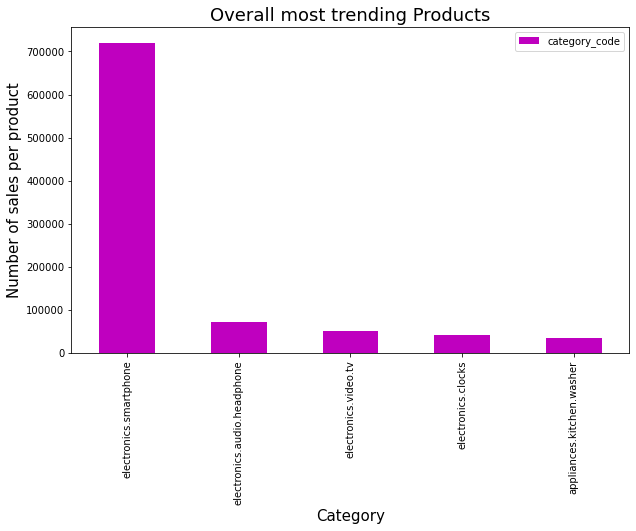

In [25]:
result = df_purc.groupby('category_code').category_code.count().nlargest()
result = result.compute()
result = result.plot.bar(figsize=(10,6), color='m')
plt.title('Overall most trending Products', fontsize=18)
plt.xlabel('Category', fontsize=15)
plt.ylabel('Number of sales per product', fontsize=15)
plt.legend()
plt.show()

**From the above plot we can conclude that the catagories of the most trending products are:**
1. Electronics.smartphone
2. Electronics.audio.headphone
3. Electronics.video.tv
4. Electronics.clocks
5. Appliances.kitchen.washer

#### Now we plot  for each month the same information ( most trending products per category )
- First the data is sorted by the index column 'event_time', in order to retrieve the dataset of October and November. This also allows for faster access, joins, groupby-apply operations.

In [26]:
df_idx = df_purc.set_index('event_time')  
df_idx = df_idx.persist()   # Persist data in memory.This allows future computations to be much faster

In [45]:
df_oct = df_idx['2019-10']  # By selecting 2019-10 and 2019-11 we filter the dataframe that correspond to the month October and November respectively  
df_nov = df_idx['2019-11']

#### To plot Oct. most trending product 
- take df_oct dataframe, which is previously filtered by data_type == 'purchase'  
- group by category_code and count the latter
- plot the five largest numbers which correspond to Oct. most trending products

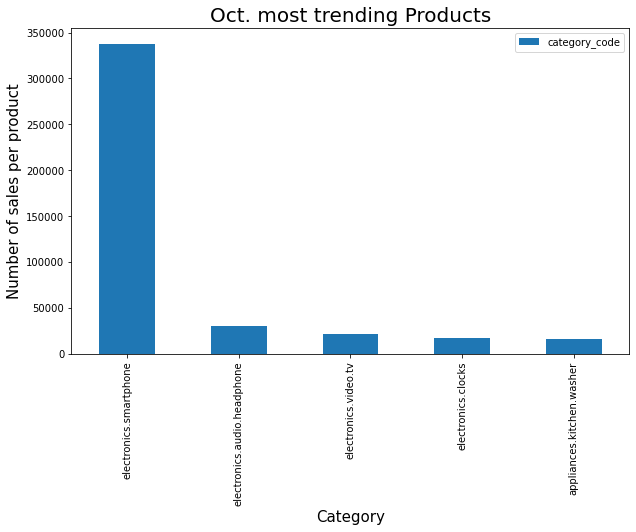

In [40]:
result_oct = df_oct.groupby('category_code').category_code.count().nlargest()
result_oct = result_oct.compute()
result_oct = result_oct.plot.bar(figsize=(10,6))
plt.title('Oct. most trending products', fontsize=18)
plt.xlabel('Category', fontsize=15)
plt.ylabel('Number of sales per product', fontsize=15)
plt.legend()
plt.show()

**From the above plot we can conclude that October's most trending products are the following catagories:**
1. Electronics.smartphone
2. Electronics.audio.headphone
3. Electronics.video.tv
4. Electronics.clocks
5. Appliances.kitchen.washer

#### Same procedure to plot Nov. most trending product  

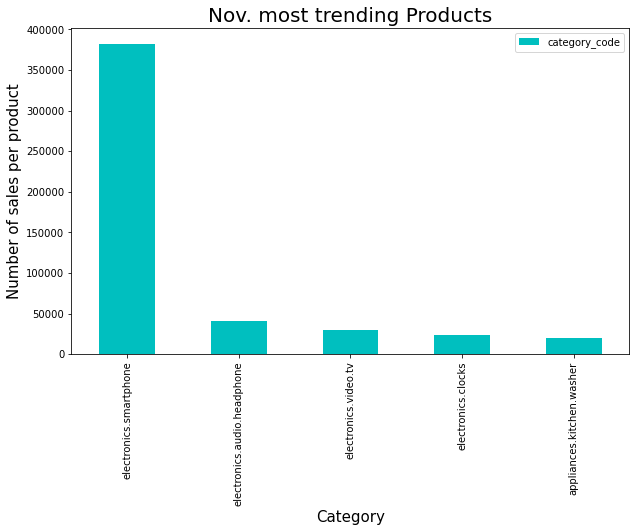

In [42]:
result_nov = df_nov.groupby('category_code').category_code.count().nlargest()
result_nov = result_nov.compute()
result_nov = result_nov.plot.bar(figsize=(10,6), color='c')
plt.title('Nov. most trending products', fontsize=18)
plt.xlabel('Category', fontsize=15)
plt.ylabel('Number of sales per product', fontsize=15)
plt.legend()
plt.show()

**November's most trending products are the same as October's catagories:**
1. Electronics.smartphone
2. Electronics.audio.headphone
3. Electronics.video.tv
4. Electronics.clocks
5. Appliances.kitchen.washer

#### 2.1 Plot the most visited subcategories
- filter the dataframe by 'view' event_type
- group by category_code and count the latter
- plot the five largest numbers which represent to the most visited subcatagories

In [26]:
df_2 = df[['event_type', 'category_code']]
df_2view = df_2[df_2.event_type == 'view']

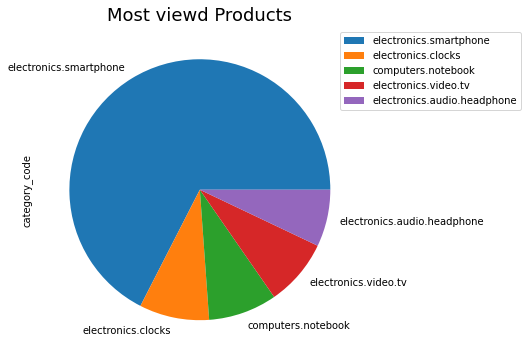

In [27]:
result = df_2view.groupby('category_code').category_code.count().nlargest()
result = result.compute()
result = result.plot.pie(figsize=(10,6))
plt.title('Most viewd Products', fontsize=18)
#plt.xlabel('Category', fontsize=15)
#plt.ylabel('Number of views per category', fontsize=15)
plt.legend(fontsize=10,  bbox_to_anchor=(1.5,1), loc='upper right')
plt.show()

**From the above plot we can conclude that the most visited catagories are:**
1. Electronics.smartphone
2. Electronics.clocks 
3. Computers.notebook
4. Electronics.video.tv
5. Electronics.audio.headphone

#### 2.2 What are the 10 most sold products per category?

- filter the dataframe by 'purchase' event_type
- group by category_code, count the latter and sort  
- plot the ten largest numbers which represent the most sold products per catagory

In [28]:
df_2purc = df_2[df_2.event_type == 'purchase']

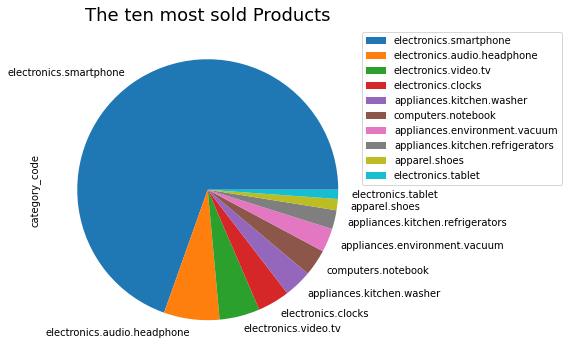

In [30]:
result = df_2purc.groupby('category_code').category_code.count().nlargest(10)
result = result.compute()
result = result.plot.pie(figsize=(10,6))
plt.title('The ten most sold Products', fontsize=18)
#plt.xlabel('Category', fontsize=15)
#plt.ylabel('Number of views per category', fontsize=15)
plt.legend(fontsize=10, bbox_to_anchor=(1.6,1), loc='upper right')
plt.show()

## *RQ 3.1*
#### *Write a function that asks the user a category in input and returns a plot indicating the average price of the products sold by the brand.*

What is the category you are looking for? 2053013558920217191


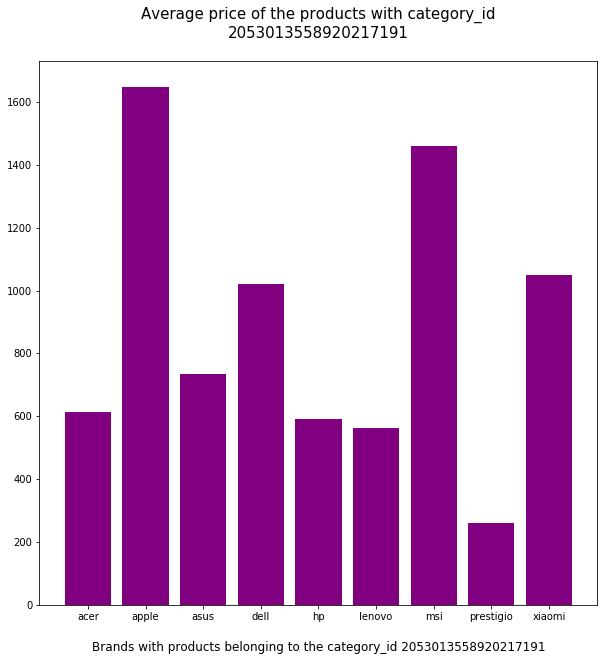

In [7]:
#Ex 3.1 

def my_fun(x):
    
    my_dict = {}
    my_dict['sums'] = x['price'].sum()
    my_dict['counts'] = x['price'].count()
    
    return pd.Series(my_dict, index = ['sums', 'counts'])


#define a function that takes as argument the category_id chosen by the user, that we'll call my_category
def my_func(my_category = input("What is the category you are looking for? ")):
    
    plt.figure(figsize=(10,10))

#inizialize an empty dataframe
    data = pd.DataFrame()
    
#for each chunck of October's dataset...
    for chunck in pd.read_csv('2019-Oct.csv', usecols = ['category_id', 'brand', 'price'], nrows = 100000,  chunksize = 1000, iterator = True):

#...if my_category is present into the chunck...
            chunck = chunck[chunck.category_id == int(my_category)]
            if len(chunck) != 0:

#...group by the brand, calculate the sum of the prices of the products belonging to my_category sold by the brand, calculate
#the number of products belonging to my_category sold by the brand and append this new information to the dataframe 
                data = data.append(pd.DataFrame(chunck.groupby('brand').apply(my_fun)))

#the same for each chunck of November's dataset
    for chunck in pd.read_csv('2019-Nov.csv', usecols = ['category_id', 'brand', 'price'],nrows = 100000,  chunksize = 1000, iterator = True):
            
            chunck = chunck[chunck.category_id == int(my_category)]
            if len(chunck) != 0:

                data = data.append(pd.DataFrame(chunck.groupby('brand').apply(my_fun)))

#repeat the same process for the dataframe filled with information...
    data = pd.DataFrame(data.groupby('brand').sum())

#and calculate the mean...
    data['means'] = data['sums']/data['counts']

#plot a plot bar
    plt.bar(data.index, data['means'], color = "purple")
    plt.title("Average price of the products with category_id\n"+ my_category +"\n", fontsize = 15)
    plt.xlabel("\nBrands with products belonging to the category_id "+ my_category, fontsize = 12)
    plt.show()

my_func()           


#### Comment
In order to solved this research question, we used as input from the user the category_id 2053013558920217191, for which we obtained that the brand with the highest average price of the products belonging to that category is Apple

## *RQ 3.2*
#### *Find, for each category, the brand with the highest average price. Return all the results in ascending order by price.*

In [8]:
#Ex 3.2 

import warnings
warnings.filterwarnings("ignore")

def my_fun(x):
    
    my_dict = {}
    
    my_dict['sums'] = x['price'].sum()
    my_dict['counts'] = x['price'].count()
    
    return pd.Series(my_dict, index = ['sums', 'counts'])

#define an empty dataframe and an empty numeric variable
data = pd.DataFrame(columns = ['categories', 'sums', 'counts'])
i = 0

#for each chunck of October's dataset...
for chunck in pd.read_csv('2019-Oct.csv', usecols = ['category_id', 'brand', 'price'], nrows = 100000, chunksize = 1000, iterator = True):
    
#...for each category belonging to the chunck...
    for category_id, frame in chunck.groupby('category_id'):
        
        chunck = chunck[chunck.category_id == category_id]
        if len(chunck) != 0:

#...group by brand, calculate the sum of the prices of the products belonging to that category sold by the brand, calculate the
#number of products belonging to that category sold by the brand and append this new information to the dataframe
            arg = pd.DataFrame(chunck.groupby('brand').apply(my_fun))
            my_len = len(arg)
            data = data.append(arg)
            for j in range(i, i+my_len):
    
#add information about the category we are referring to
                data['categories'][j] = category_id
            i = i + my_len
            
#the same for each chunck of November's dataset
for chunck in pd.read_csv('2019-Nov.csv', usecols = ['category_id', 'brand', 'price'], nrows = 100000, chunksize = 1000, iterator = True):
    
    for category_id, frame in chunck.groupby('category_id'):
        
        chunck = chunck[chunck.category_id == category_id]
        if len(chunck) != 0:
            
            arg = pd.DataFrame(chunck.groupby('brand').apply(my_fun))
            my_len = len(arg)
            data = data.append(arg)
            for j in range(i, i+my_len):
                data['categories'][j] = category_id
            i = i + my_len

#calculate the means...
data['means'] = data['sums']/data['counts']

#...and initialize an empty dataframe where to put  the brand with the highest average price and the average price 
my_data = pd.DataFrame(columns = ['brands', 'prices'])
my_data['brands'] = data.groupby('categories').means.idxmax()
my_data['prices'] = data.groupby('categories').means.max()

#sort the dataframe by the values of the variable 'prices'
my_data.sort_values(by = 'prices', inplace = True)
print(my_data)


                      brands       prices
categories                               
2053013552695869677    huion   112.440000
2053013552326770905  ariston   112.831667
2053013552293216471  almacom   137.710000
2053013552385491165   xiaomi   231.640000
2053013552226107603    deton   462.610000
2053013552351936731  samsung   582.158333
2053013552259662037   daewoo  2548.020000


#### Comment
From this table we can see for different categories the brands with the highest average prices and the average prices. We might comment that these prices are very variable, depending on the category we are referring to

### 4.  How much does each brand earn per month? Write a function that given the name of a brand in input returns, for each month, its profit. Is the average price of products of different brands significantly different?
    4.1 Using the function you just created, find the top 3 brands that have suffered the biggest losses in earnings between one month and the next

In [45]:
df_4 = df[['event_time', 'event_type', 'brand', 'price']]  # Select only the columns that we plan to use

In [49]:
df_4 = df_4[df_4.brand.notnull()]  # Remove unlabeled brands 

In [104]:
df_4pur = df_4[df_4['event_type'] == 'purchase']  # Select only the 'perchase' event_type

In [105]:
df_idx = df_4pur.set_index('event_time')  # indexing 'time_event' (not a column anymore)
df_idx = df_idx.persist()   # Persist data in memory.This allows future computations to be much faster

In [106]:
df_oct = df_idx['2019-10']  # By selecting 2019-10 and 2019-11 we filter the dataframe that correspond to the month October and November respectively  
df_nov = df_idx['2019-11']

#### Let us define a function ‘brand_profit’ which takes as an input the brands name and returns its profit for the month of October and November.
- define 'df_1', which filter the dataset of October based on the name of the brand (input of the function)
- define 'df_2', filter Novembers dataset on the given brands name
- 'oct_pro' yield the total sum of the purchased brand for the month of October
- likewise, 'nov_pro' gives us the total purchased price of the given brand 
- the function returns for the given brand name a tuple containing its profit of October and November   

In [108]:
def brand_profit (df_oct, df_nov, brand_name):
    df_1 = df_oct[df_oct.brand == brand_name].compute()
    df_2 = df_nov[df_nov.brand == brand_name].compute()
    oct_pro = df_1.price.sum()
    nov_pro = df_2.price.sum()
    return (int(oct_pro), int(nov_pro))

In [178]:
brand_profit(df_oct, df_nov, 'xiaomi')

(9194033, 11259865)

#### Assessment of the difference between the average price of different brands 
- select the column of interest from the dataset (and we need all the event_type here, not only ‘purchase’) 
- groupby brand and compute the sum of price for each brand
- likewise, groupby brand and count the number of products of the same brand
- calculate the average price of products per brand and plot 

#### From the obtained plot we can infer that there is indeed a significant average price difference across different brands

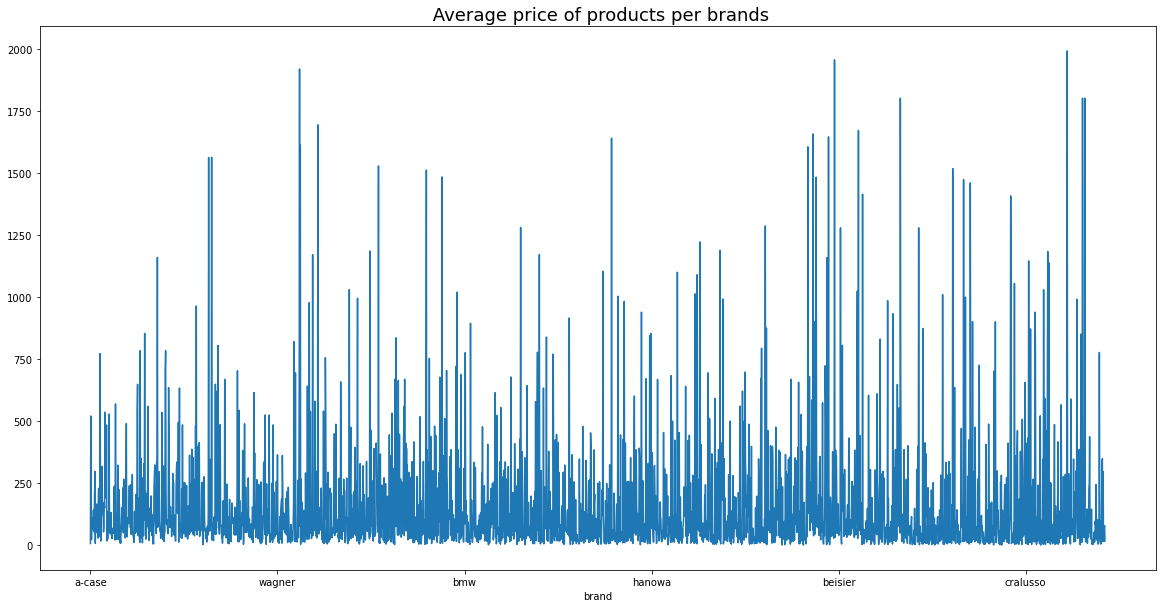

In [179]:
tot_sale = df_4[['brand', 'price']].groupby('brand').price.sum().compute()
num_prod = df_4[['brand', 'price']].groupby('brand').brand.count().compute()
avg_sale = tot_sale / num_prod
avg_sale.plot(figsize=(20,10))
plt.title(' Average price of products per brands', fontsize=18)
plt.show()

#### 4.1 find the top 3 brands that have suffered the biggest losses in earnings
- because the function returns a tuple of two elements, first element October’s profit and second element Novembers profit, we calculate the percentage loss only if October’s profit is greater than that’s of November
- the result is appended to a list 'loss_perc'(initially empty ), to keep track of the correspondence between the unique brands and their profit loss, we append zero to the list when Octobers profit results lower than that of November
- create a tuple of unique brand and percentage loss and sort the latter 
- this yield the names and the percentage loss of the brands that have suffered the biggest loss between October and November

In [117]:
unq_bra = df_4.brand.unique().compute()  # List of unique brands

In [118]:
loss_perc = []
for i in unq_bra:
    profit = brand_profit(df_oct, df_nov, i)
    if profit[0] > profit[1]:
        x = ((profit[0] - profit[1]) * 100) / profit[0]
        loss_perc.append(x)
    else:
        loss_perc.append(0)              

In [182]:
proflos_bra = list(zip(loss_perc, unq_bra))
proflos_bra.sort(reverse=True)
proflos_bra

[(100.0, 'zic'),
 (100.0, 'zenmart'),
 (100.0, 'zegan'),
 (100.0, 'zara'),
 (100.0, 'yuandong'),
 (100.0, 'yota'),
 (100.0, 'yokatta'),
 (100.0, 'yh'),
 (100.0, 'xxr'),
 (100.0, 'ww'),
 (100.0, 'wsp'),
 (100.0, 'worwo'),
 (100.0, 'wk'),
 (100.0, 'wilo'),
 (100.0, 'wess'),
 (100.0, 'wella'),
 (100.0, 'wangfeng'),
 (100.0, 'vokul'),
 (100.0, 'vip'),
 (100.0, 'vionne'),
 (100.0, 'vibe'),
 (100.0, 'venti'),
 (100.0, 'unikum'),
 (100.0, 'tuarex'),
 (100.0, 'trespass'),
 (100.0, 'toysmax'),
 (100.0, 'thorvik'),
 (100.0, 'telwin'),
 (100.0, 'tec'),
 (100.0, 'sunsuki'),
 (100.0, 'stikbot'),
 (100.0, 'sterntaler'),
 (100.0, 'steger'),
 (100.0, 'steelflex'),
 (100.0, 'steba'),
 (100.0, 'standard'),
 (100.0, 'sportbaby'),
 (100.0, 'specialized'),
 (100.0, 'sowell'),
 (100.0, 'soundstream'),
 (100.0, 'soundking'),
 (100.0, 'solaris'),
 (100.0, 'sokany'),
 (100.0, 'smiger'),
 (100.0, 'sly'),
 (100.0, 'sluban'),
 (100.0, 'slider'),
 (100.0, 'skylor'),
 (100.0, 'skil'),
 (100.0, 'ship'),
 (100.0, 'sc

#### Taking into consideration that the percentage loss results 100% when there is no purchase event for that brand in the month of November, we conclude that the three brands that have suffered the most are
1. Jonnesway 96.65% loss
2. Sunfull 96.00% loss
3. Evga 95.903% loss

## *RQ 5*

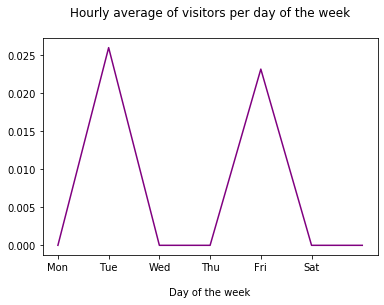

In [9]:
# Ex 5 

#inizialize an empty dataframe and a list filled with 7 zeros
data = pd.DataFrame(columns = ['day', 'users'])
l = [0, 0, 0, 0, 0, 0, 0]

#for each chunck of October's dataset...
for chunck in pd.read_csv('2019-Oct.csv', usecols = ['event_time', 'user_id'], parse_dates = ['event_time'], date_parser = pd.to_datetime, nrows = 100000, chunksize = 1000, iterator = True):
    
#...for every day of the week...
    for i in range(0, 7):

#initialize an empty numeric variable
        my_sum = 0
        chunck_day = chunck[chunck.event_time.dt.dayofweek == i]
    
#if at least one user made an operation during the ith day of the week...
        if len(chunck_day) != 0:
        
#...fill the ith position of the list with the number of operations made during the ith day of the week 
            l[i] += len(chunck_day)
    
#increase my_sum of the number of users who made any operation during the ith day of the week...
            my_sum += chunck_day.groupby('user_id').user_id.unique().count()

#...and append the new information to the dataframe
        data = data.append(pd.DataFrame([[i, my_sum]], columns = ['day', 'users']))
        
#the same for each chunck of November's dataset 
for chunck in pd.read_csv('2019-Nov.csv', usecols = ['event_time', 'user_id'], parse_dates = ['event_time'], date_parser = pd.to_datetime, nrows = 100000, chunksize = 1000, iterator = True):
    
    for i in range(0, 7):
        
        my_sum = 0
        chunck_day = chunck[chunck.event_time.dt.dayofweek == i]
        if len(chunck_day) != 0:
            
            l[i] += len(chunck_day)
            my_sum += chunck_day.groupby('user_id').user_id.unique().count()
        
        data = data.append(pd.DataFrame([[i, my_sum]], columns = ['day', 'users']))
        
#repeat the same process for the dataframe filled with information...
data = data.groupby('day').users.sum()

for i in range(len(l)):
    if l[i] == 0:
        l[i] = 1

#plot
plt.plot((data.values/l)/24, color = 'purple')
plt.title("Hourly average of visitors per day of the week\n")
plt.xlabel("\nDay of the week")
plt.xticks(range(0,6), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.show()


#### Comment
From this plot we can see that Tuesday and Friday were the two most active days of the week, while Monday, Thursday, Wednesday, Saturday and Sunday weren't active days at all

### 6. The conversion rate of a product is given by the number of times a product has been bought over the number of times it has been visited. What's the conversion rate of your online store?
    6.1 Find the overall conversion rate of your store
    6.2 Plot the number of purchases of each category and show the conversion rate of each category in decreasing order

#### The conversion rate of the online store is calculated by
- Select from the dataset only the column we are interested in
- Select the list of the unique products present in the store
- Check for each unique products the event that is the number of times the unique product appears in the column df_6['product_id'] and if the product has been purchased or viewed.  This yield for each unique product the number of times that has been purchased and viewed.
- Find the conversion rate for each product.

In [ ]:
df_6 = df[['event_type', 'product_id', 'category_code']]  # Select only the columns that we plan to use

In [ ]:
unq_pro = df_6.product_id.unique().compute()  # List of unique products 
tot_pro = df_6.product_id.compute()  # List of all products present In the dataset of Oct and Nov (same product might appear multiple times)  

In [ ]:
num_pur = []
for i in range (len(unq_pro)):
    for j in range (len(tot_pro)):
        if (tot_pro[j] == unq_pro[i]) & (df_6.event_type[j] == 'purchase'):
            num_pur[i] += 1

In [ ]:
num_view = []
for i in range (len(unq_pro)):
    for j in range (len(tot_pro)):
        if (tot_pro[j] == products[i]) & (df_6.event_type[j] == 'purchase'):
            num_view += 1

In [ ]:
conversion_rate = (num_pur / num_view)
conversion_rate

#### 6.1 Find the overall conversion rate of your store
- filter the dataframe by 'purchase' event_type and count the unique 'product_id'
- filter the dataframe by 'view' event_type and count the unique 'product_id'  
- the overall conversion rate is given by the proportion of the total number of purchased products to viewd products

In [ ]:
df_6purc = df_6[df_6.event_type == 'purchase']
n_purc = df_6purc['product_id'].nunique().compute()

In [30]:
df_6view = df_6[df_6.event_type == 'view']
n_view = df_6view['product_id'].nunique().compute()

In [53]:
Overall_conversion_rate = (n_purc / n_view)
Overall_conversion_rate

0.3290666872909376

#### 6.2 Plot the number of purchases of each category and show the conversion rate of each category in decreasing order
- filter the dataframe by 'purchase' event_type
- groupby 'category_code' and count the event_type ('purchase'), this gives the number of purchase per category
- plot the result

In [49]:
df_6purc = df_6[df_6.event_type == 'purchase']
purc_cat = df_6purc.groupby('category_code').event_type.count().compute()

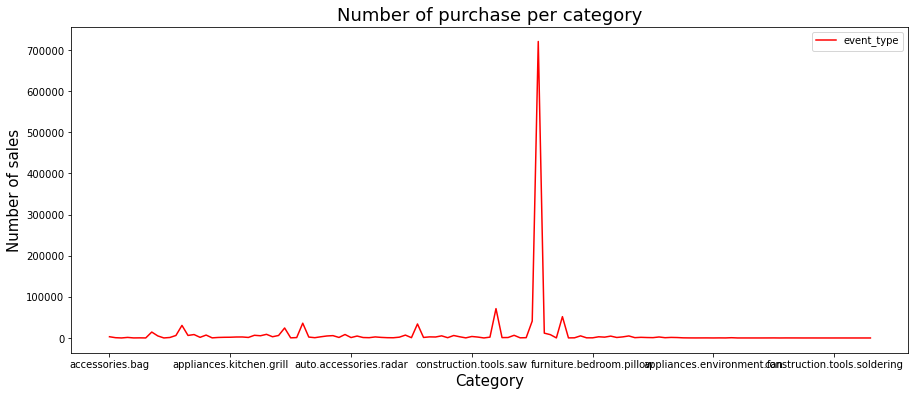

In [53]:
purc_cat.plot(figsize=(15,6), color='r')
plt.title('Number of purchase per category', fontsize=18)
plt.xlabel('Category', fontsize=15)
plt.ylabel('Number of sales', fontsize=15)
plt.legend()
plt.show()

**to obtain the conversion rate per category in decreasing order:**
- filter the dataframe by 'purchase' event_type, groupby 'category_code' and count the unique 'product_id'
- filter the dataframe by 'view' event_type, groupby 'category_code' and count the unique 'product_id'  
- the conversion rate per category is given by the proportion of the total number of purchased products to viewd products per category
- sort the conversion rate in descending order
- plot the result

In [12]:
df_6purc = df_6[df_6.event_type == 'purchase']
purc_cat = df_6purc.groupby(['category_code'])['product_id'].nunique().compute()

In [83]:
purc_cat

category_code
accessories.bag                  778
accessories.wallet               229
apparel.belt                      24
apparel.costume                  179
apparel.dress                     60
                                ... 
country_yard.furniture.hammok      1
apparel.shorts                     3
appliances.kitchen.fryer           1
construction.tools.screw           1
apparel.jacket                     1
Name: product_id, Length: 127, dtype: int64

In [13]:
df_6view = df_6[df_6.event_type == 'view']
view_cat = df_6view.groupby(['category_code'])['product_id'].nunique().compute()

In [85]:
view_cat

category_code
accessories.bag             2479
accessories.umbrella          37
accessories.wallet           614
apparel.belt                  87
apparel.costume              461
                            ... 
apparel.glove                124
apparel.skirt                161
apparel.jacket                11
construction.tools.screw      12
appliances.kitchen.fryer       1
Name: product_id, Length: 129, dtype: int64

In [37]:
convrate_cate = (purc_cat / view_cat)
convrate_cate = convrate_cate.sort_values(ascending=False)

In [38]:
convrate_cate

category_code
appliances.kitchen.fryer           1.000000
computers.ebooks                   0.848485
auto.accessories.radar             0.780822
electronics.smartphone             0.755132
appliances.kitchen.meat_grinder    0.751852
                                     ...   
apparel.shoes.sandals              0.063804
apparel.underwear                  0.050948
apparel.shorts                     0.034483
apparel.shoes.espadrilles               NaN
country_yard.furniture.bench            NaN
Name: product_id, Length: 129, dtype: float64

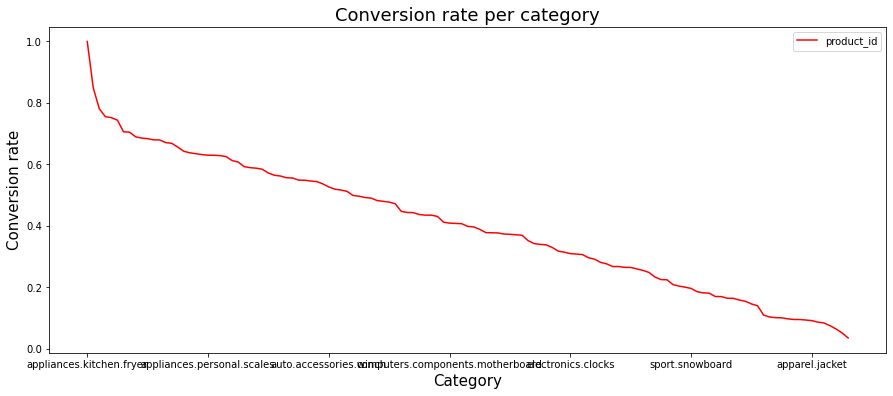

In [29]:
convrate_cate.plot(figsize=(15,6), color='r')
plt.title('Conversion rate per category', fontsize=18)
plt.xlabel('Category', fontsize=15)
plt.ylabel('Conversion rate', fontsize=15)
plt.legend()
plt.show()

- **confront purchase per category with conversion rate per category**

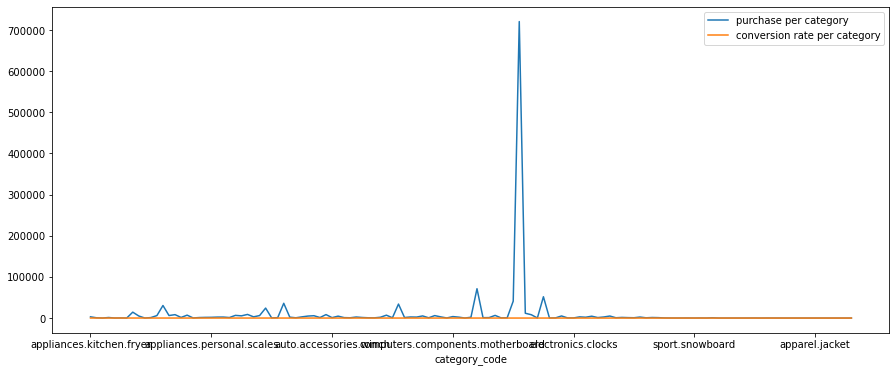

In [61]:
plt.figure(figsize=(15,6))
purc_cat.plot(label='purchase per category')
(convrate_cate * 100).plot(label='conversion rate per category')  # conversion rate in percentage 
plt.legend()
plt.show()

## *RQ 7*
#### *Prove that the pareto principle applies to your store.*

In [10]:
#Ex 7 

#initialize 2 empty numeric variables and an empty dataframe
earnings = 0
buyers = 0
earnings_per_user = pd.DataFrame()

#for each chunck of October's dataset...
for chunck in pd.read_csv('2019-Oct.csv', usecols = ['event_type', 'price', 'user_id'], nrows = 100000, chunksize = 1000, iterator = True):
    
    chunck_purchase = chunck[chunck.event_type == 'purchase']  
    if len(chunck_purchase) != 0:
        
#...increase earnings of the prices of the products purchased...
        earnings += chunck_purchase['price'].sum()
    
#...increase buyers of the number of user who purchased any product...
        buyers += chunck_purchase['user_id'].count()
    
#group by user and append to the dataframe the prices of the products purchased by each user
        earnings_per_user = earnings_per_user.append(pd.DataFrame(chunck_purchase.groupby('user_id').price.sum()))
    
#the same for each chunck of November's dataset
for chunck in pd.read_csv('2019-Nov.csv', usecols = ['event_type', 'price', 'user_id'], nrows = 100000, chunksize = 1000, iterator = True):
    
    chunck_purchase = chunck[chunck.event_type == 'purchase']  
    if len(chunck_purchase) != 0:
        earnings += chunck_purchase['price'].sum()
        buyers += chunck_purchase['user_id'].count()
        earnings_per_user = earnings_per_user.append(pd.DataFrame(chunck_purchase.groupby('user_id').price.sum()))

#calculate the 80% of the earnings
earnings80 = round(earnings*.8, 2)

#count the top 20% buyers
buyers20 = int(buyers*.2)

#group by user and calculate the prices of the products purchased by each user
earnings_per_user = earnings_per_user.groupby('user_id').price.sum()
top_earnings = round(earnings_per_user.sort_values(ascending = False).head(buyers20).sum(), 2)

print("The Pareto Principle can be applied to the store: the 20% of the users have spent "+ str(top_earnings) +"$ , which is close to the 80% of the earnings: "+ str(earnings80) +"$")


The Pareto Principle can be applied to the store: the 20% of the users have spent 621530.65$ , which is close to the 80% of the earnings: 722243.05$


#### Comment
This result simply shows that the Pareto principle can be applied to the e-commerce store